# Final Project - TRON Tournament

## 1. Set-up

In [1]:
# Import any libraries you might need to develop our agent.
import numpy as np
import matplotlib
import time
import signal
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML, clear_output
import copy

## 2. Agent

The task is to implement an agent using a technique discussed during the class. Your agent should be able to beat random player ~99% of the time, and must comply with a  time limit of 5 seconds per move. Furthermore, you cannot modify the game board directly; any projects that do so that will be disqualified.

In [34]:
# TODO: Implement your agent here by modifying the 'choose_move' function.
# Do not change the instantiation function or any of the function signatures.
# TODO: Implement your agent here.
import math
import threading
class PlayerAgent:
    def __init__(self, player_id):
        self.player_id = player_id  # play turn
        self.calculation_time = 4  # maximum calculation time
        self.max_actions = 1000  # max simulated actions
        self.confident = 1.96
        self.equivalence = 1000 # calc beta
        self.plays = {}
        self.wins = {}
        self.max_depth = 1
        self.count = 1
        self.simulations = 0
    def choose_move(self, game):
        print(self.count)
        self.count += 1
        self.simulations = 0
        # Get an array of legal moves from your current position.
        legal_moves = game.get_legal_moves(self.player_id)

        my_board = game.board
        # if there is only one place to move
        if len(legal_moves) == 1:
            # print(legal_moves)
            return legal_moves[0]
        self.plays = {}
        self.wins = {}

        threads = []
        nloops = 20
        board_copy = copy.deepcopy(my_board)

        for i in range(nloops):
            t = threading.Thread(target=self.start_thread, args=(board_copy,self.player_id,game))
            threads.append(t)

        for i in range(nloops):
            threads[i].start()

        for i in range(nloops):
            threads[i].join()

        # print("total simulations:", self.simulations)
        move = self.select_one_move(my_board,game)
        # print("maximum depth searched:", self.max_depth)
        # print("I choose:",move)

        return move
    def start_thread(self,board_copy,current_player,game):
        begin = time.time()
        # simulation = 0
        while time.time() - begin < self.calculation_time:

            self.start_simulation(board_copy, current_player, game)
            # simulation+=1
        # self.simulations +=simulation
    def start_simulation(self, board_copy, current_player, game):

        available_moves = game.get_legal_moves(current_player, board_copy)
        move = available_moves[0]
        visited_states = set()
        winner = -1
        expand = True
        for turn in range(1, self.max_actions + 1):
            if len(available_moves)>0:
                if all(self.plays.get((current_player, str(move))) for move in available_moves):
                    log_total = math.log(sum(self.plays[(current_player, str(move))] for move in available_moves))

                    value, move = max(((self.wins[(current_player, str(move))] / self.plays[(current_player, str(move))]) + np.sqrt(
                        self.confident * log_total / self.plays[(current_player,str(move))]), move) for move in available_moves)

                    board_copy = game.examine_move(current_player, move, board_copy)
                else:
                    adjacents = []
                    move = available_moves[0]

                    board_copy = game.examine_move(current_player, move, board_copy)

                if expand and (current_player, str(move)) not in self.plays:
                    expand = False
                    self.plays[(current_player, str(move))] = 0
                    self.wins[(current_player, str(move))] = 0

                    if turn > self.max_depth:
                        self.max_depth = turn

                visited_states.add((current_player,str(move)))
                win, winner = self.has_a_winner(board_copy, current_player, game)
                if win:
                    break
                current_player = 3 if current_player == 1 else 1
                available_moves = game.get_legal_moves(current_player, board_copy)
            else:
                winner = 3 if current_player == 1 else 1
        for player,move in visited_states:
            if (player,move) in self.plays:
                self.plays[(player,move)]+=1
                if player==winner:
                    self.wins[(player,move)]+=1


    def select_one_move(self,board,game):
        percent_wins, move = max((self.wins.get((self.player_id,str(move)),0)/self.plays.get((self.player_id,str(move)),1),move) for move in game.get_legal_moves(self.player_id,board))
        return move

    def has_a_winner(self, board, current_player, game):
        legal_moves = game.get_legal_moves(current_player, board)
        if len(legal_moves) == 0:
            if current_player == 1:
                return True, 3
            else:
                return True, 1
        else:
            return False, -1
            # Choose an action to take based on the algorithm you
            # decide to implement. This method should return
            # one of the items in the 'legal_moves' array.



# This is an example of an agent which simply picks a move at random.
class RandomAgent:

    def __init__(self, player_id):
        self.player_id = player_id

    def choose_move(self, game):
        # Get an array of legal moves from your current position.
        legal_moves = game.get_legal_moves(self.player_id)
        
        # Shuffle the legal moves and pick the first one. This is equivalent
        # to choosing a move randomly with no logic.
        np.random.shuffle(legal_moves)
        return legal_moves[0]

## 3. Environment

This is the game environment. It will probably be helpful to have an understanding of how the game works,
so we reccomend reading through the implementation.

**!!!!! Do not modify the game's implementation !!!!!**


In [35]:
# This handler will be used to time-out actions/games which take too long to compute.
# Note that this handler does not function on Windows based systems.
# def signal_handler(signum, frame):
#     raise TimeoutError("Timed out!")
#signal.signal(signal.SIGALRM, signal_handler)


class TronGame:

    def __init__(self, agent1_class, agent2_class, board_size, board_type):
        # Default board.
        if board_type == 'default':
            self.size = board_size
        # Board with obstacles and a fixed size of 10x10.
        elif board_type == 'obstacles':
            self.size = 10
        elif board_type == 'rocky':
            self.size = board_size            
        else:
            raise ValueError('Invalid board type.')

        # Build the game board.
        self.board_type = board_type
        self.board = self.build_board(board_type)

        # Initialize the game state variables and set the values using the 
        # 'reset_game()' method.
        self.reset_game()

        # Initialize our agents.
        self.agent1 = agent1_class(1)
        self.agent2 = agent2_class(3)

    def build_board(self, board_type):
        """
        This method takes a board_type: ['default', 'obstacles'] and returns a 
        new board (NumPy matrix).
        """

        # Default board.
        if board_type == 'default':
            board = np.zeros((self.size, self.size))
            board[0, 0] = 1
            board[self.size - 1, self.size - 1] = 3

        # Board with obstacles and a fixed size of 10x10.
        elif board_type == 'obstacles':
            board = np.zeros((10, 10))
            board[1, 4] = 1
            board[8, 4] = 3
            board[3:7, 0:4] = 4
            board[3:7, 6:] = 4
        # Board with obstacles and a fixed size of 10x10.
        elif board_type == 'rocky':
            board = np.zeros((self.size, self.size))
            a=np.random.randint(2,size=(self.size,self.size))
            b=np.random.randint(2,size=(self.size,self.size))
            c=np.random.randint(2,size=(self.size,self.size))
            d=np.random.randint(2,size=(self.size,self.size))

            board=board+(a*b*c*d)*4
            board[0, 0] = 1
            board[self.size-1, self.size-1] = 3
                      

        else:
            raise ValueError('Invalid board type.')

        return board

    def reset_game(self):
        """ 
        Helper method which re-initializes the game state.
        """
        
        self.board = self.build_board(self.board_type)

    def get_player_position(self, player_id, board=None):
        """
        Helper method which finds the coordinate of the specified player ID
        on the board.
        """
        
        if board is None:
            board = self.board
        coords = np.asarray(board == player_id).nonzero()
        coords = np.stack((coords[0], coords[1]), 1)
        coords = np.reshape(coords, (-1, 2))
        return coords[0]

    def get_legal_moves(self, player, board=None):
        """
        This method returns a list of legal moves for a given player ID and
        board.
        """
        
        if board is None:
            board = self.board

        # Get the current player position and then check for all possible
        # legal moves.
        prev = self.get_player_position(player,board)
        moves = []
        
        # Up
        if (prev[0] != 0) and (board[prev[0] - 1, prev[1]] == 0):
            moves.append([prev[0] - 1, prev[1]])
        # Down
        if (prev[0] != self.size - 1) and (board[prev[0] + 1, prev[1]] == 0):
            moves.append([prev[0] + 1, prev[1]])
        # Left
        if (prev[1] != 0) and (board[prev[0], prev[1] - 1] == 0):
            moves.append([prev[0], prev[1] - 1])
        # Right
        if (prev[1] != self.size - 1) and (board[prev[0], prev[1] + 1] == 0):
            moves.append([prev[0], prev[1] + 1])
            
        return moves

    def examine_move(self, player, coordinate, board):
        board_clone = board.copy()
        prev = self.get_player_position(player, board_clone)
        board_clone[prev[0], prev[1]] = 4
        board_clone[coordinate[0], coordinate[1]] = player
        return board_clone

    @staticmethod
    def view_game(board_history):
        """
        This is a helper function which takes a board history 
        (i.e., a list of board states) and creates an animation of the game 
        as it progresses.
        """

        fig, ax = plt.subplots()
        colors = ['black', 'blue', 'pink', 'white', 'red', 'yellow']
        cmap = matplotlib.colors.ListedColormap(colors)
        bounds = np.linspace(0, 5, 6)
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
        matrix = ax.matshow(board_history[0], cmap=cmap, norm=norm)

        def update(i):
            matrix.set_array(board_history[i])
            return matrix

        ani = FuncAnimation(fig, update, frames=len(board_history), interval=100)
        plt.show()
        return HTML(ani.to_html5_video())

    def play_series(self, num_games, debug=True):
        """
        This method plays a series of games between the two agents.

        It returns two objects: (i) a tuple which indicates the number of 
        wins per player, and (ii) a history of the board state as the game 
        progresses.
        """

        wins_player_1 = 0
        wins_player_2 = 0
        games = []
        for i in range(num_games):
            winning_player_id, board_history = self.__play_game(debug=debug)
            games.append(board_history)

            if winning_player_id == 1:
                wins_player_1 += 1
            elif winning_player_id == 2:
                wins_player_2 += 1
            else:
                raise ValueError('Invalid winning player ID.')

        print(f'Finished playing [{num_games}] games.')
        print(f'Player 1 won [{wins_player_1}] games and has a win-rate of [{wins_player_1 / num_games * 100}%].')
        print(f'Player 2 won [{wins_player_2}] games and has a win-rate of [{wins_player_2 / num_games * 100}%].')
        return (wins_player_1, wins_player_2), games

    def __apply_move(self, player, coordinate):
        """
        This private method moves a player ID to a new coordinate and obstructs
        the previously occupied tile.
        """
        
        prev_coord = self.get_player_position(player)

        self.board[prev_coord[0], prev_coord[1]] = 4
        self.board[coordinate[0], coordinate[1]] = player

    def __play_game(self, debug=True):
        """
        This private method plays a single game between the two agents. It
        returns the winning player ID as well as the history of the board
        as the game progresses.
        """
        
        # Reset the game.
        self.reset_game()
        board_history = []

        # Play the game until it's conclusion.
        while True:
            # ---------------------------------------
            # PLAYER 1's TURN
            # ---------------------------------------
            # Check legal moves.
            poss_moves = self.get_legal_moves(1)
            if not len(poss_moves):
                if debug:
                    print("Player 2 wins")
                winning_player_id = 2
                break

            # Compute and apply the chosen move.
            # signal.alarm(3)
            try:
                move = self.agent1.choose_move(self)
            except Exception:
                print("There was an error while choosing a move.")
                print("Player 2 wins")
                winning_player_id = 2
                break
            self.__apply_move(1, move)
            
            # Record keeping.
            board_history.append(np.array(self.board.copy()))
            if debug:
                print(self.board)
                time.sleep(.5)
                clear_output()

            # ---------------------------------------
            # PLAYER 2's TURN
            # ---------------------------------------
            # Check legal moves.
            poss_moves = self.get_legal_moves(3)
            if not len(poss_moves):
                if debug:
                    print("Player 1 wins")
                winning_player_id = 1
                break
                
            # Compute and apply the chosen move.
            # signal.alarm(3)
            try:
                move = self.agent2.choose_move(self)
            except Exception:
                print("There was an error while choosing a move.")
                print("Player 1 wins")
                winning_player_id = 1
                break
            self.__apply_move(3, move)

            # Record keeping.
            board_history.append(np.array(self.board.copy()))
            if debug:
                print(self.board)
                time.sleep(.5)
                clear_output()
        # signal.alarm(0)

        return winning_player_id, board_history

## 4. Development

In [38]:
my_tron_game = TronGame(board_size=20,
                        agent1_class=RandomAgent,
                        agent2_class=PlayerAgent,
                        board_type="default")

(player1_wins, player2_wins), game_histories = my_tron_game.play_series(num_games=3, debug=False)

1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


Finished playing [3] games.
Player 1 won [0] games and has a win-rate of [0.0%].
Player 2 won [3] games and has a win-rate of [100.0%].


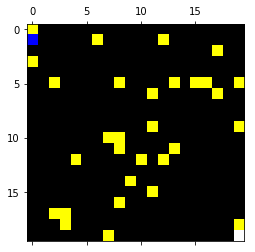

<video width="432" height="288" controls autoplay loop>
  <source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA83G1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA9GZYiE
ABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAFpyZQ/tiefQszNTuABLgE1W7LoUQ4qkD
/LdbXJlRyyFxZjQqJViR/kOg4RNNI56Xh1SKLVpGoBGPvlhcGUw3xpQe2yx4P0mg6CaVf4XXX/10
GEYy4Ai5YoKgctsp9vk6dR8W7Cnbdoq1kQ7R+AY9O2TG1AyoCKvx0TEDyj4CVEbTldFcxbJQ4jaF
T+Rt5DYlQ1eNHxME2E/pu1TTrxXJ1aR2aBFpzdZSnq1Cudm8kr+6zJnvMRwAxZ0OlKz1jLvHy+3s
tNaClu42VysCRXwjUVR3ZneA2Hps3NIME97pXTkjTBECbdEUM4QzxejPWKgb2JkQnIDMt53Mdaly
YpQk8Svk0XLKGBO6zHa7U4+vXOshlb9KmgaQ2ijEjnAClf8sYmkmxCJJengEhP1XgMDYfWR/6z7P
wa7+Q+jr4Iv2fZ+05RDTiY4UuxmlItNaaZfF0/Ehd+niVzlgeg75yiDumbI9jtg9jc9oZ9RTBsAA
0YS8jxDNatzZs6mhxksFiOrEecLKS8DUmIR8bQaCu3lLIHxuJWZ8ohb0KUwrH/RfW21Iug95WxjG
LwSZdD14dMkqGORAewFQVuBjbDPCtteS2MXmeCZM8df5CW5HztEU/rd0f/8ydqF3TrWOrE7Z3usy
//JQ0JGLACZ2h8l3vh4ddp9zBJyWUowmsRKnIbV6ZgnUHSr0k6uPkDg0jmYfXXF2b0k3CasvJgbC
h9TKxH//He0DP3WpL7bvDKQpAbI/M9B5mj9dTEhkXOiEu//8Qjypx7hh1HaxlrpyVexUyRxZ42DZ
5Bg8BKEbaoJMRloZ+nNF7IdDXfgzT4uhOpXF+zv5VXI3/RIBhbF5opybWqS/8P5nnGPK+2KVf1tq
kWMuC7U05HAn/MIsmyGuhE1T3b7Ca6wR/xSniL1HckMAjuZ3wtYLRvk8hP3J1Q/a8B3yZKNeACta
t1mg5Byq474cX1pKcAD6QVCE38ZYKOdq3M23EgwU80YoUKb6H4IeKtDiXmQTW8kWsFIatKaxeU9r
/wV2B92aR0Q3heHVOPLqQr2KUPG71KBqGf1g74TGrXdnzfin8uGyyk2WfkkeMEstfuXBYa+fNxnI
m0XpHV1b1YSn/Ov+Z+iFzL9/iB7z4diL1OAV+ZrnWeOTZQotahv5iE2V6qBTU6cw0YHYoYCiUp15
5jyRcXgB+/rRpvZkNZ0SXnX/3l0ONiF/8Me0O9k0tFmhBYb6esSOpmX5hMpvS/9muObl/nwSYlWY
cnjsrWQWxHgkk/SARpjXRgIYc+Ix88JLZ06hZPZC9Avb/qCMu96paRbXeFlt14FYjWVPJLpY2pya
ixntHu7nX7dwb25m9zTWXNIwNL9KTgy4m5ssagwqJ8uGob1U3XhWvfMuQ2Au/dDypHRofq0fqf50
pBAfpIVB48z6hpW1ES7Ys4TtNdVokeMjgwKiEx+//cyVxkEk7sVeefHFiiOMdapDs5Q/y9xkH82F
PaoQWGLQ3Qeib/VS7VA91chFm5q/XWEsNhRC9tRpjmOlnl6JBrWH/kv4Y1On8hjSs2TeDwo5a8pA
mPcX8l4s7f7OY6bq0jERZy4A8UrL0+DBIc3GrKFVsLKsYYEFRFaTpkfegIccDBHA/VgZXTgkzaob
X+6j3mGAuQOpuUFDPZDgUiF1XZCjLJ1vXvACEuerBvU4RH1UBF0vdXJOFuVX0i8qxJn05rD3RszL
fUcXPyHrnZpPflHCGqCYX5Z8obdw92XPmPdJ9zET60aSXOv5QyoCyac9lvHn1S0DqOzaGJa7Fv8S
uwHx7HRTV0UBk7wAph/lAS+cxlLx0RdlKgkSe7ZYZ1rB1zphX/c7qC2A5ZZZk+JKnks/YCoBuW2s
ucqBaI5wS6LGwvXz/Cf39RQKYEINDG/4INOrc8adgIqM0gK5CbNUf8gSbRph66oekdEr6tLyGFFR
6J/pmMZT/dH+ONr5qXWOdz43IKoPdWA1mk3nzwSt1wus/oOAp4w6J2ldP8JZkbicvaqUyR5Hd/fc
XTekxheL6+e6TU+7goj4U8ZiuoFA59xqzsDakrjYqCRtssSkT2iUGFJv1j9FtufTFylBf94U7GE4
1tL1V5Es4wqFz7cKqLee9U6/4eunT11WvPGG5FdGqRxTFdH/db9sj61nnC+mggFQtSEocta0TrY5
WxNpA5BrzgNFbdQbbOWmfdxg4qtkynAXlB14m6bNMxwEY2mm9T4hx2dzl47Pr/TSG2mXwIwFrzc7
Y2Vk4/p4eAfkTCFoFpmwiCxd2C5hzZ+F3V0VEqXsz2887bL3HEnueBkyojsBdkA3yN/r1Kj3eMN/
mhX6mbSjpM/EfNImjkFxCVSJbDfjDDgWAoQ2Nle9T4m81u7KD6QwY3VOOk5eDizNzMwdHwWUlws3
JXIsfnUluK8NHz9FaUVNmrPfL5tJp25B+plYocBz9cSpuD/h378GxmL/dzddpgIa1OGQBORKQjAC
mnDkGFf+h03utcMBNifvSYobX7vO29/yYaHkczuuJzkGYnO9/W1AYiCAcwAmHvT9WbYbfX9K3H5F
XSqu2O7/EVgyktj67vn+ckLkaOwWzBUZb8Zyay7ETa+mcxivWIhDoUIYw11hi3WirHMtyVAAKBCh
4tQSX1hBVDRCuhWaSaldlmGCChIm+du2TCJ6YjlYo0AZ3h4+ISQ59kzpBqs/ri5F3tSS5HjpzdXN
6fxn5XAQlkx+/7UEUs0f+9G9Is7uXeKOXn5gDHJZmCFRNoevKiAuhh7ObJxSJsNcJwhtcYrBaZ7e
XeiLKZOgGi3dcPCTYQQ9/Jz+KaqamzK9ui9GyZBT

In [24]:
TronGame.view_game(game_histories[0])

TclError: ignored